# Hard drive failure prediction for SAS disks

Особый интерес для исследований представляют SAS диски, так как они используются в современных СХД и серверах. SAS диски представляют smart параметры, отличные от smart параметров SATA дисков (представленных в существующих статьях на тему прогнозирования отказов дисков).

Пример SMART репорта SAS диска может быть найден [тут](https://hardforum.com/threads/seagate-sas-in-sm-jbod-lots-of-read-errors-anyone-else.1878472/) и [тут](http://sg.danny.cz/scsi/smartmontools_scsi.html).

Документация к SMART параметрам SAS дисков:
- [smartmontools scsi](https://www.smartmontools.org/browser/trunk/www/smartmontools_scsi.xml)
- [scsi sas nvme does not provide SATA like attributes](https://www.smartmontools.org/wiki/FAQ#MySCSISASdriveisnotinthesmartctlsmartddatabase)



Примерное отображение SATA параметров в SAS:

| SMART parameter for SATA | SATA SMART id | SMART parameter for SAS|
| --- | --- | --- |
| Power-on Time hours | 09  | Number of hours powered up| 
|(HDA) temperature | 194 | Current Drive Temperature | 
| Reallocated sectors count | 05 | Grown defects list |
|Read error rate | 01 | Total uncorrected errors read (?) | 
|Write error rate | 200 | Uncorrected errors write + corrected errors write (?) |
|Reported uncorrectable errors | 187 | Total uncorrected (sum?)|
| Load / unload cycle count | 193 | Accumulated load / unload cycles |
| Start / stop count | 04 | Accumulated start / stop cycles |
| Hardware ECC recovered | 195 | ECC delayed / fast (?) |
| Soft ECC correction | 204 | ECC delayed / fast (?) | 

Оставим только эти параметры для исследовавшегося ранее BackBlaze датасета SATA дисков. Возможно, выводы, основанные на таком датасете, могут пригодиться для датасета реальных SAS дисков.

## Investigating dataset with potential SAS disks parameters
### Preliminary

In [4]:
import pandas as pd

# Concatenating all datasets (one dataset per month 2017) to one
##df_bb = pd.concat(map(pd.read_csv, glob.glob("./backblaze_ST4000DM000/*.csv")))
df_bb = pd.read_csv('./backblaze_ST4000DM000/model_2018_ST4000DM000.csv')
df_bb.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2018-01-01,Z3016TK2,ST4000DM000,4000787030016,0,115.0,87117728.0,NaN,NaN,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,W300GLSS,ST4000DM000,4000787030016,1,111.0,40108520.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,Z302SXQ0,ST4000DM000,4000787030016,0,119.0,208926768.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,Z3025L3F,ST4000DM000,4000787030016,1,111.0,30947064.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,Z302SW9C,ST4000DM000,4000787030016,0,117.0,137764288.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_bb.shape

(380078, 105)

In [6]:
df_bb['failure'].value_counts()

0    367482
1     12596
Name: failure, dtype: int64

In [7]:
df_bb_normalized = df_bb[df_bb.columns.drop(list(df_bb.filter(regex='normalized')))]
feat_names_normalized = df_bb_normalized.columns.values
print("Dataset with normalized features values", feat_names_normalized)
print(df_bb_normalized.shape)

Dataset with normalized features values ['date' 'serial_number' 'model' 'capacity_bytes' 'failure' 'smart_1_raw'
 'smart_2_raw' 'smart_3_raw' 'smart_4_raw' 'smart_5_raw' 'smart_7_raw'
 'smart_8_raw' 'smart_9_raw' 'smart_10_raw' 'smart_11_raw' 'smart_12_raw'
 'smart_13_raw' 'smart_15_raw' 'smart_22_raw' 'smart_177_raw'
 'smart_179_raw' 'smart_181_raw' 'smart_182_raw' 'smart_183_raw'
 'smart_184_raw' 'smart_187_raw' 'smart_188_raw' 'smart_189_raw'
 'smart_190_raw' 'smart_191_raw' 'smart_192_raw' 'smart_193_raw'
 'smart_194_raw' 'smart_195_raw' 'smart_196_raw' 'smart_197_raw'
 'smart_198_raw' 'smart_199_raw' 'smart_200_raw' 'smart_201_raw'
 'smart_220_raw' 'smart_222_raw' 'smart_223_raw' 'smart_224_raw'
 'smart_225_raw' 'smart_226_raw' 'smart_235_raw' 'smart_240_raw'
 'smart_241_raw' 'smart_242_raw' 'smart_250_raw' 'smart_251_raw'
 'smart_252_raw' 'smart_254_raw' 'smart_255_raw']
(380078, 55)


In [8]:
columns_with_values = df_bb_normalized.columns[df_bb_normalized.isnull().sum() <= 100]
df_bb_normalized = df_bb_normalized[columns_with_values]
df_bb_normalized.isnull().sum()

date               0
serial_number      0
model              0
capacity_bytes     0
failure            0
smart_1_raw       16
smart_3_raw       16
smart_4_raw       16
smart_5_raw       16
smart_7_raw       16
smart_9_raw       16
smart_10_raw      16
smart_12_raw      16
smart_183_raw     16
smart_184_raw     16
smart_187_raw     16
smart_188_raw     16
smart_189_raw     16
smart_190_raw     16
smart_191_raw     16
smart_192_raw     16
smart_193_raw     16
smart_194_raw     16
smart_197_raw     16
smart_198_raw     16
smart_199_raw     16
smart_240_raw     16
smart_241_raw     16
smart_242_raw     16
dtype: int64

Нужны параметры: 1, 4, 5, 9, 187, 193, 194, 200

In [12]:
sas_params = ['failure', 'smart_1_normalized', 'smart_4_normalized', 'smart_5_normalized', 
              'smart_9_normalized', 'smart_187_normalized', 
              'smart_193_normalized', 'smart_194_normalized'] #, 'smart_204_normalized', 'smart_195_normalized']
sas_params = ['failure', 'smart_1_raw', 'smart_4_raw', 'smart_5_raw',
'smart_9_raw', 'smart_187_raw', 'smart_193_raw', 'smart_194_raw']
df_bb_normalized = df_bb_normalized[sas_params]

In [13]:
df_bb_normalized.isnull().sum()

failure           0
smart_1_raw      16
smart_4_raw      16
smart_5_raw      16
smart_9_raw      16
smart_187_raw    16
smart_193_raw    16
smart_194_raw    16
dtype: int64

In [14]:
df_bb_normalized.shape

(380078, 8)

In [15]:
df_bb_normalized = df_bb_normalized.dropna()
df_bb_normalized.shape

(380062, 8)

In [16]:
df_bb_normalized.isnull().sum()

failure          0
smart_1_raw      0
smart_4_raw      0
smart_5_raw      0
smart_9_raw      0
smart_187_raw    0
smart_193_raw    0
smart_194_raw    0
dtype: int64

In [17]:
df_renamed = df_bb_normalized
#df_renamed = df_renamed.rename(columns={
#    "smart_1_normalized":"read error rate", 
#    "smart_4_normalized":"accumulated start-stop cycles",
#    "smart_5_normalized": "reallocated sectors count",
#    "smart_9_normalized":"accumulated power on time hours",
#    "smart_187_normalized": "reported uncorrectable errors",
#    "smart_193_normalized":"accumulated load-unload cycles",
#    "smart_194_normalized": "current temperature",
#    "smart_200_normalized":"write error rate"})

df_renamed = df_renamed.rename(columns={
    "smart_1_raw":"read error rate", 
    "smart_4_raw":"accumulated start-stop cycles",
    "smart_5_raw": "reallocated sectors count",
    "smart_9_raw":"accumulated power on time hours",
    "smart_187_raw": "reported uncorrectable errors",
    "smart_193_raw":"accumulated load-unload cycles",
    "smart_194_raw": "current temperature",
    "smart_200_raw":"write error rate"})

In [18]:
df_renamed.head()

,failure,read error rate,accumulated start-stop cycles,reallocated sectors count,accumulated power on time hours,reported uncorrectable errors,accumulated load-unload cycles,current temperature
0,0,87117728.0,4.0,0.0,33507.0,0.0,4579.0,30.0
1,1,40108520.0,30.0,0.0,37030.0,0.0,61458.0,24.0
2,0,208926768.0,6.0,0.0,20702.0,0.0,20677.0,31.0
3,1,30947064.0,8.0,0.0,28373.0,0.0,10785.0,23.0
4,0,137764288.0,9.0,0.0,19979.0,0.0,10574.0,36.0


In [19]:
df_renamed['read error rate'].value_counts() # read error rate

47320568.0     14
176636704.0    14
14004288.0     14
78017432.0     14
207211584.0    14
               ..
183291544.0     1
119587912.0     1
13324040.0      1
31026752.0      1
228126392.0     1
Name: read error rate, Length: 377440, dtype: int64

In [20]:
df_renamed['accumulated start-stop cycles'].value_counts() # start stop count

6.0       31754
4.0       29492
5.0       28969
7.0       27139
9.0       25797
          ...  
1287.0        9
1114.0        9
69.0          6
1507.0        6
1224.0        1
Name: accumulated start-stop cycles, Length: 69, dtype: int64

In [21]:
df_renamed['reallocated sectors count'].value_counts()

0.0        377063
8.0          1625
16.0          259
48.0          145
24.0          121
            ...  
33784.0         1
33712.0         1
33480.0         1
33400.0         1
2424.0          1
Name: reallocated sectors count, Length: 176, dtype: int64

In [22]:
df_renamed['accumulated power on time hours'].value_counts()

23839.0    106
23815.0    103
23791.0    102
23743.0     97
23767.0     96
          ... 
8868.0       1
31451.0      1
4752.0       1
15055.0      1
32338.0      1
Name: accumulated power on time hours, Length: 30213, dtype: int64

In [23]:
df_renamed['reported uncorrectable errors'].value_counts()

0.0     368721
1.0       2743
2.0       1843
6.0       1418
3.0        776
7.0        591
18.0       576
4.0        444
5.0        372
8.0        346
12.0       310
9.0        288
13.0       210
10.0       132
30.0       127
20.0       117
16.0       108
27.0       101
21.0        94
36.0        82
48.0        76
11.0        74
78.0        70
63.0        70
24.0        58
54.0        48
17.0        32
15.0        31
26.0        30
14.0        30
23.0        23
32.0        20
44.0        19
65.0        16
39.0        15
38.0        11
22.0        10
28.0         5
29.0         4
31.0         4
33.0         3
40.0         2
52.0         1
25.0         1
62.0         1
69.0         1
43.0         1
73.0         1
88.0         1
79.0         1
51.0         1
53.0         1
49.0         1
41.0         1
Name: reported uncorrectable errors, dtype: int64

In [24]:
df_renamed['accumulated load-unload cycles'].value_counts()

53011.0     127
9129.0      127
20348.0     125
19421.0     119
42632.0     117
           ... 
53272.0       1
14427.0       1
95728.0       1
54072.0       1
259806.0      1
Name: accumulated load-unload cycles, Length: 47040, dtype: int64

In [25]:
df_renamed['current temperature'].value_counts()

23.0     52959
22.0     49001
24.0     39821
21.0     36168
20.0     33732
25.0     30052
26.0     25152
19.0     22112
27.0     18042
28.0     13301
29.0     11706
18.0     10654
30.0      8828
31.0      6901
32.0      5503
17.0      4248
33.0      3226
34.0      2754
35.0      2682
36.0      1054
16.0       892
37.0       553
38.0       265
15.0       163
39.0        76
40.0        41
49.0        34
50.0        34
48.0        21
47.0        20
46.0        17
14.0        13
44.0        11
45.0         6
51.0         6
43.0         6
141.0        5
41.0         3
Name: current temperature, dtype: int64

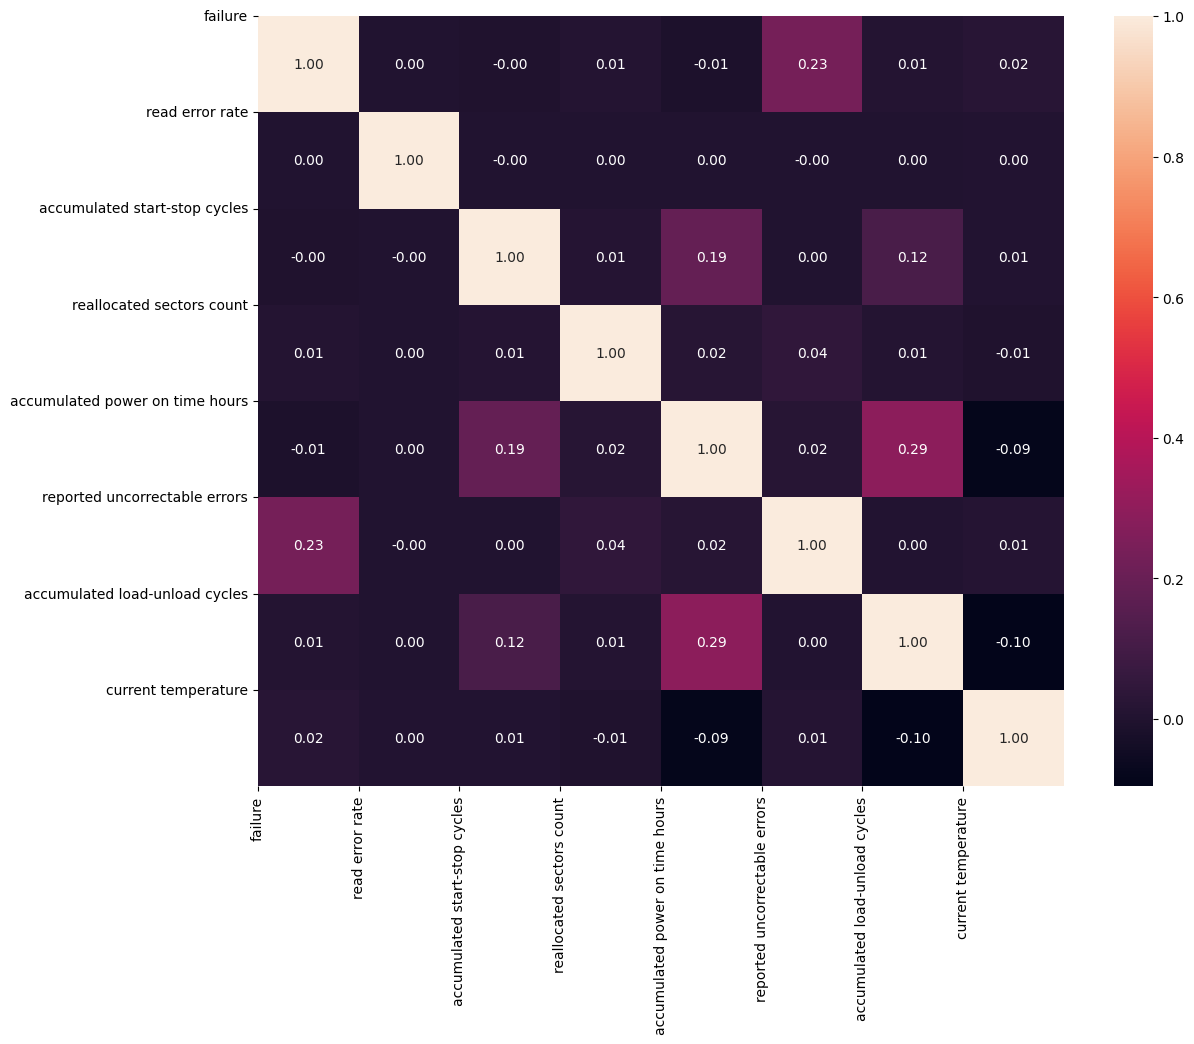

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#df_bb_numeric = df_bb_normalized.drop(columns=string_columns, axis=1)

corr = df_renamed.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(13, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

Из матрицы корелляций можно отметить, что:
- reported uncorrectable errors достаточно коррелирует с failure (0.23)
- accumulated start-stop cycles немного коррелирует с accumulated load-unload cycles (0.12) (*было видно на _raw данных и не видно на нормализованных*)
- accumulated load-unload cycles достаточно коррелирует с accumulated power on time hours (0.32) 
- accumulated start-stop cycles немного коррелирует с accumulated power on time hours (0.19) (*было видно на _raw данных и не видно на нормализованных*)
- current temperature немного коррелирует с accumulated load-unload cycles (0.14)
- accumulated power on time hours немного кореллирует с current temperature (0.09)

### Splitting data

In [20]:
from sklearn.model_selection import train_test_split

X = df_bb_normalized.drop('failure', axis=1)
y = df_bb_normalized['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (285046, 7)
Shape of X_test:  (95016, 7)
Shape of y_train:  (285046,)
Shape of y_test (95016,)


### Applying models

#### Applying RF

In [21]:
from sklearn.ensemble import RandomForestClassifier
import time 

clf = RandomForestClassifier(n_estimators=10, random_state=42)

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
clf.fit(X_train, y_train)
print(time.strftime("%H:%M:%S", time.localtime()))

20:45:29
20:45:31


Training set accuracy:  0.9846901903552409
Test set accuracy:  0.9764671213269344


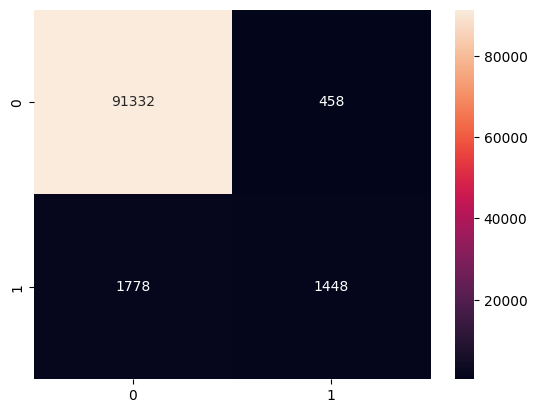

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred_train = clf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training set accuracy: ", accuracy_train)

y_pred_test = clf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: ", accuracy_test)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.show()

#### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
knn.fit(X_train, y_train)
print(time.strftime("%H:%M:%S", time.localtime()))
print(X_train.shape, X_test.shape)

20:45:32
20:45:33
(285046, 7) (95016, 7)


Training set accuracy:  0.9804978845519671
Test set accuracy:  0.9745306053717269


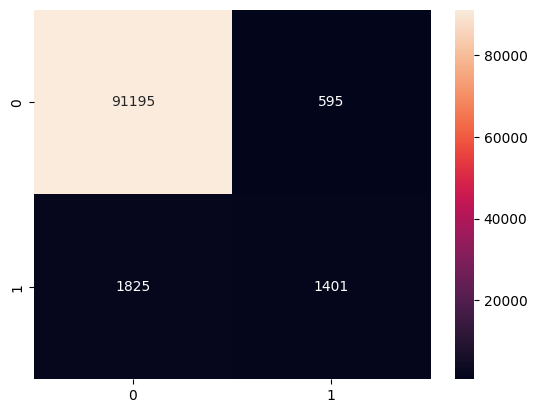

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred_train = knn.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training set accuracy: ", accuracy_train)

y_pred_test = knn.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: ", accuracy_test)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.show()

#### SVM

In [ ]:
import time
from sklearn.svm import SVC

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
model = SVC(random_state=42)
model.fit(X_train, y_train)
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

20:46:16


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training set accuracy: ", accuracy_train)

y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: ", accuracy_test)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.show()

#### BPNN 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

In [ ]:
model = Sequential()
model.add(Dense(10, input_shape=(7,), activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=10)

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
y_pred_test = (model.predict(X_test) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_test, y_pred_test)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.show()